<a href="https://colab.research.google.com/github/Phrmth/New/blob/master/Neural_Net_from_scratch_on_Boston_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import tensor
from torch import nn
import torch.nn.functional as F
import torch
from torch import optim

from torch.utils.data import DataLoader, TensorDataset

In [100]:
# Data

from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
X = torch.from_numpy(X.astype(np.float32)); y = torch.from_numpy(y.astype(np.float32)); X.shape, y.shape

(torch.Size([506, 13]), torch.Size([506]))

In [101]:
# Creating train and validation dataset
x_train  = X[0:450]; x_valid = X[450:506] ; y_train = y[0:450]; y_valid = y[450:506]
x_train.shape,y_train.shape,x_valid.shape, y_valid.shape

(torch.Size([450, 13]),
 torch.Size([450]),
 torch.Size([56, 13]),
 torch.Size([56]))

In [0]:
# Normalizing with train data's mean and std 

def normalize(x, valid = None, test = None ):
  x_mean = x.mean(dim = 0)
  x_std = x.std(dim = 0 ) 
  if test : x = valid
  return (x - x_mean)/x_std

In [103]:
# Normalizing train and valid dataset
x_norm = normalize(x_train); x_valid= normalize(x_train,x_valid,True)
x_norm.shape, x_valid.shape

(torch.Size([450, 13]), torch.Size([56, 13]))

In [104]:
y.mean(),y_valid.mean()

(tensor(22.5328), tensor(18.4286))

In [0]:
dl_train = DataLoader(TensorDataset(x_norm, y_train.view(-1,1)), batch_size = 25, shuffle = True)
dl_valid = DataLoader(TensorDataset(x_valid, y_valid.view(-1,1)), batch_size = 56, shuffle = False)

In [0]:
if torch.cuda.is_available():
 device = torch.device("cuda")
else : device = torch.device("cpu")

In [0]:
m = x_train.shape[1]
nh = 10
lr = 1e-2
loss_func = nn.MSELoss()
def get_model():
  Model = nn.Sequential(nn.Linear(m,nh),
                        nn.ReLU(),
                        nn.Linear(nh,5),
                        nn.ReLU(),
                        nn.Linear(5,1)
                        )
  return Model, optim.Adam(Model.parameters(), lr=lr, eps = 1e-7 )

In [0]:
model, opt = get_model()

In [0]:
from torch.nn import init

for l in model:
  if isinstance(l, nn.Linear):
    init.kaiming_normal_(l.weight)

In [0]:
def fit(epoch, model , dl_train, dl_valid, opt, loss_func ):
  train_loss = []
  valid_loss = []
  loss1 = []
  loss2 = []
  model.to(device)
  for l in range(epoch):
    
    for xb, yb in dl_train:

      model.train()
      opt.zero_grad()
      xb,yb = xb.to(device),yb.to(device)
      pred = model(xb)
      loss = loss_func(pred,yb)
      loss.backward()

      opt.step()
      loss1.append(loss)
    print(sum(loss1)/len(loss1))
      # with torch.no_grad():
      #   for p in model.parameters(): p-= p.grad * lr

    model.eval()
    with torch.no_grad():
      for xv,yv in dl_valid:
        
        xv,yv = xv.to(device),yv.to(device)
        pred = model(xv)
        loss_v = loss_func(pred,yv)

        loss2.append(loss_v)
      print(sum(loss2)/len(loss2))

      
    train_loss.append(loss)
    valid_loss.append(loss_v)
    print(f"Epoch{l} : Train Loss {loss}, Valid Loss {loss_v}")
  
  return train_loss, valid_loss


In [111]:
loss , loss_v = fit(25, model, dl_train, dl_valid, opt, loss_func)

tensor(463.6221, device='cuda:0', grad_fn=<DivBackward0>)
tensor(327.2107, device='cuda:0')
Epoch0 : Train Loss 291.4832458496094, Valid Loss 327.2106628417969
tensor(349.3394, device='cuda:0', grad_fn=<DivBackward0>)
tensor(257.8405, device='cuda:0')
Epoch1 : Train Loss 138.08982849121094, Valid Loss 188.47032165527344
tensor(271.2732, device='cuda:0', grad_fn=<DivBackward0>)
tensor(193.8567, device='cuda:0')
Epoch2 : Train Loss 96.45905303955078, Valid Loss 65.88895416259766
tensor(217.1800, device='cuda:0', grad_fn=<DivBackward0>)
tensor(161.7581, device='cuda:0')
Epoch3 : Train Loss 40.6922492980957, Valid Loss 65.46256256103516
tensor(180.0558, device='cuda:0', grad_fn=<DivBackward0>)
tensor(142.8743, device='cuda:0')
Epoch4 : Train Loss 24.02202796936035, Valid Loss 67.33894348144531
tensor(154.6363, device='cuda:0', grad_fn=<DivBackward0>)
tensor(127.5359, device='cuda:0')
Epoch5 : Train Loss 9.479389190673828, Valid Loss 50.84415817260742
tensor(136.0453, device='cuda:0', grad_

In [78]:
loss_v

[array(154.80185, dtype=float32), array(207.85164, dtype=float32)]

kaiming initialization of weights give a less curvy gradient descent , plot for the last 25 epochs , it took 75 epochs to get the error at this point. 



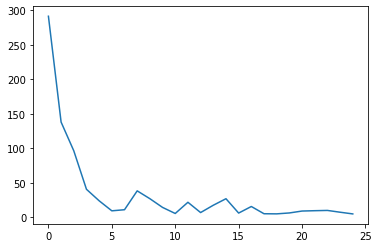

In [112]:
plt.plot(range(25),loss)
# plt.plot(range(25),loss_v)

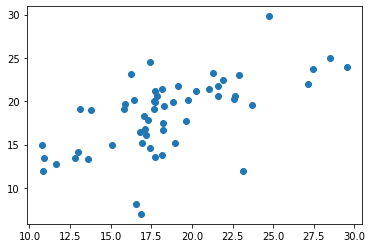

In [206]:
torch.Tensor.ndim = property(lambda self: len(self.shape))  # Fix it
for xv, yv in dl_valid:
  model = model.to('cpu')
  pred = model(xv)
  plt.scatter(pred.detach().numpy(), yv.detach().numpy())

In [0]:
model.predict()